In [359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

Function for data frame manipulations that are same for all data frames.

In [360]:
def df_maniplualtion(path):
    data_frame = pd.read_csv(path)
    data_frame = data_frame.rename(columns={"Name": "Date"})
    data_frame["Date"] = pd.to_datetime(data_frame["Date"], format="%d/%m/%Y")
    data_frame['Date'] = data_frame['Date'].dt.strftime('%Y-%m')
    data_frame.set_index('Date', inplace=True)
    return data_frame

Dependant variable data frame

In [361]:
dependentVariable = df_maniplualtion('data/depVariable.csv')

Monthly data

In [362]:
monthlyIndex = df_maniplualtion('data/Monthly.csv')

Change variable

In [363]:
changeVariables = df_maniplualtion('data/changeVariable.csv')

Smoothed 10 years earnings to price ratio

In [364]:
smoothedEP = df_maniplualtion('data/smoothedPE.csv')

Variance data frame, I don't use df_manipulation function because we need day information.

In [365]:
stockVariance = pd.read_csv('data/stockVar.csv')
stockVariance = stockVariance.rename(columns={"Name": "Date"})
stockVariance["Date"] = pd.to_datetime(stockVariance["Date"], format="%d/%m/%Y")
stockVariance.set_index('Date', inplace=True)

stockVariance = stockVariance.rename(columns={"JAPAN-DS Market - PRICE INDEX": "var"})

Net equity expansion

In [366]:
netIssue = df_maniplualtion('data/netEquExp.csv')

In [367]:
notCompVwretd = pd.DataFrame(dependentVariable["JAPAN-DS Market - TOT RETURN IND"].pct_change(1) - ((dependentVariable["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"]/100)/12))

Excess market return following Li et al (2013) for regression: log(1+ret%) - log (1+tbill%)

In [368]:
dependentVariable["JAPAN-DS Market - TOT RETURN IND"] = np.log(dependentVariable["JAPAN-DS Market - TOT RETURN IND"]/dependentVariable["JAPAN-DS Market - TOT RETURN IND"].shift(1))

dependentVariable["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"] = np.log(1+(dependentVariable["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"]/100)/12)

dependentVariable["JAPAN-DS Market - TOT RETURN IND"] -= dependentVariable["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"]

dependentVariable = dependentVariable.drop(columns=["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"])
dependentVariable = dependentVariable.rename(columns={"JAPAN-DS Market - TOT RETURN IND": "totalReturnChange"})
dependentVariable = dependentVariable.dropna()

/Users/jessekeranen/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Help variables for valuation ratios

In [369]:
dividends = monthlyIndex["JAPAN-DS Market - PRICE INDEX"]/monthlyIndex["JAPAN-DS Market - TOT RETURN IND"]
price = dividends/monthlyIndex["JAPAN-DS Market - DIVIDEND YIELD"]*100
earnings = price/monthlyIndex["JAPAN-DS Market - PER"]
dividendPriceRatio = pd.DataFrame(monthlyIndex["JAPAN-DS Market - DIVIDEND YIELD"]/100)
dividendPriceRatio = dividendPriceRatio.rename(columns={dividendPriceRatio.columns[0]: "D/P"})
bookToMarketRatio = 1/pd.DataFrame(monthlyIndex["JAPAN-DS Market - PRICE/BOOK RATIO"])
bookToMarketRatio = bookToMarketRatio.rename(columns={"JAPAN-DS Market - PRICE/BOOK RATIO": "B/M"})

earningsToPriceRatio = 1/pd.DataFrame(monthlyIndex["JAPAN-DS Market - PER"])
earningsToPriceRatio = earningsToPriceRatio.rename(columns={"JAPAN-DS Market - PER": "E/P"})

Volatility and variance variables

In [370]:
volatilityIndex = pd.DataFrame(np.log(1 + changeVariables["NIKKEI STOCK AVERAGE VOLATILITY INDEX - PRICE INDEX"].diff() / changeVariables["NIKKEI STOCK AVERAGE VOLATILITY INDEX - PRICE INDEX"].shift(1)))

volatilityIndex = volatilityIndex.dropna()
volatilityIndex = volatilityIndex.rename(columns={volatilityIndex.columns[0]: "Vola"})

/Users/jessekeranen/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [371]:
stockVariance = pd.DataFrame((stockVariance["var"].diff() / stockVariance["var"].shift(1)).dropna())

Here my results differ a bit from Conway's results. Maybe we can discuss this next time we meet.

In [372]:
stockVariance = stockVariance.rolling(8044, min_periods=2).var()
stockVariance = stockVariance.loc[stockVariance.groupby(stockVariance.index.to_period('M')).apply(lambda x: x.index.max())]
stockVariance.index = stockVariance.index.strftime('%Y-%m')

In [373]:
sDividends = smoothedEP["JAPAN-DS Market - PRICE INDEX"]/smoothedEP["JAPAN-DS Market - TOT RETURN IND"]
sPrice = sDividends/smoothedEP["JAPAN-DS Market - DIVIDEND YIELD"]*100
sEarnings = sPrice/smoothedEP["JAPAN-DS Market - PER"]
sEarnings = sEarnings.rolling(119).mean()
smoothedEP = sEarnings.dropna()

# Dates for December 1989 don't match in price and smoothedEP, so I change them manually.
price1 = price.copy()
price1.index.array[0] = '1989-12-29'

smoothedEP = (1/price1/smoothedEP).dropna()

# Small difference again, but not big
smoothedEP = pd.DataFrame(smoothedEP)
smoothedEP = smoothedEP.rename(columns={smoothedEP.columns[0]: "E10/P"})

In [374]:
percentEquityIssuing = pd.DataFrame(monthlyIndex["JP STOCKS: PUBLIC OFFERINGS - AMOUNT RAISED CURN"]/(monthlyIndex["JP ISSUES: CORPORATE STRAIGHT BONDS CURN"] + monthlyIndex["JP STOCKS: PUBLIC OFFERINGS - AMOUNT RAISED CURN"]))
percentEquityIssuing = pd.DataFrame(percentEquityIssuing.fillna(0))
percentEquityIssuing = percentEquityIssuing.rename(columns={percentEquityIssuing.columns[0]: "Equis"})

inflationRate = pd.DataFrame(monthlyIndex["JP CPI: NATIONAL MEASURE - ANNUAL INFLATION RATE NADJ"]/100)
inflationRate = inflationRate.rename(columns={inflationRate.columns[0]: "Ifl"})

In [375]:
def change(x, column):
    return pd.DataFrame((x[column].diff() / x[column].shift(1)).dropna())

In [376]:
realMoneySupply = change(changeVariables, "JP MONEY SUPPLY: M2 (METHO-BREAK, APR. 2003) CURA")
realMoneySupply = realMoneySupply.rename(columns={realMoneySupply.columns[0]: "Rms"})

petroleumConsumption = change(changeVariables, "JP PETROLEUM: CONSUMPTION VOLN")
petroleumConsumption = petroleumConsumption.rename(columns={petroleumConsumption.columns[0]: "PCon"})
unemploymentRate = change(changeVariables, "JP UNEMPLOYMENT RATE (METHO BREAK OCT 2010) SADJ")
unemploymentRate = unemploymentRate.rename(columns={unemploymentRate.columns[0]: "Unem"})
industrialProduction = change(changeVariables, "JP INDUSTRIAL PRODUCTION - MINING & MANUFACTURING VOLA")
industrialProduction = industrialProduction.rename(columns={industrialProduction.columns[0]: "IProd"})
crudeOilPriceChange = change(changeVariables, "US REFINERS ACQUISITION COST OF DOM. & IMPORTED CRUDE OIL CURN")
crudeOilPriceChange = crudeOilPriceChange.rename(columns={crudeOilPriceChange.columns[0]: "C/P"})
crudeOilProduction = change(changeVariables, "WD CRUDE OIL PRODUCTION - WORLD VOLN")
crudeOilProduction = crudeOilProduction.rename(columns={crudeOilProduction.columns[0]: "C/O"})

In [377]:
mv = netIssue["JAPAN-DS Market - MARKET VALUE"]

temp9 = netIssue["JAPAN-DS Market - PRICE INDEX"].diff() / netIssue["JAPAN-DS Market - PRICE INDEX"].shift(1)
netIssue = netIssue["JAPAN-DS Market - MARKET VALUE"] - netIssue["JAPAN-DS Market - MARKET VALUE"].shift(1)*(1+temp9)

#Slight differences again, could be because of rolling functions
netIssue = (netIssue.rolling(window=12, min_periods=3).sum()).dropna()
netIssue = (netIssue/mv).dropna()
netIssue = pd.DataFrame(netIssue)
netIssue = netIssue.rename(columns={netIssue.columns[0]: "Ntis"})

In [378]:
netPY = (monthlyIndex["JAPAN-DS Market - DIVIDEND YIELD"]/100) + (((changeVariables["JAPAN-DS Market - MARKET VALUE"].shift(1) * (changeVariables["JAPAN-DS Market - PRICE INDEX"]/changeVariables["JAPAN-DS Market - PRICE INDEX"].shift(1))) - changeVariables["JAPAN-DS Market - MARKET VALUE"])/changeVariables["JAPAN-DS Market - MARKET VALUE"])
netPY = pd.DataFrame((np.log(0.1 + netPY)).dropna())
netPY = netPY.rename(columns={netPY.columns[0]: "Ndy"})

/Users/jessekeranen/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [379]:
def rollingmean(length):
    temp = dependentVariable.rolling(length).mean().shift(-length)
    #temp["totalReturnChange"] = temp["totalReturnChange"].shift(1)
    temp = temp.rename(columns={temp.columns[0]: ("K" + str(length))})
    return pd.DataFrame(temp)

In [380]:
mk12 = rollingmean(12)
mk24 = rollingmean(24)
mk36 = rollingmean(36)
mk48 = rollingmean(48)

Fama and French factors

In [381]:
famafrench = pd.read_csv("data/Japan_5_Factors.csv")
famafrench["Date"] = pd.to_datetime(famafrench["Date"], format="%Y%m")
famafrench['Date'] = famafrench['Date'].dt.strftime('%Y-%m')
famafrench.set_index('Date', inplace=True)
famafrench = famafrench.loc[:].div(100)
famafrench = famafrench.drop(columns={"RF"})

mom = pd.read_csv("data/Japan_MOM_Factor.csv")
mom['Date'] = pd.to_datetime(mom["Date"], format="%Y%m")
mom['Date'] = mom['Date'].dt.strftime('%Y-%m')
mom.set_index('Date', inplace=True)
mom = mom.loc[:].div(100)

In [382]:
finalmonthlyOnlyIV = dividendPriceRatio.merge(bookToMarketRatio, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(earningsToPriceRatio, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(smoothedEP, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(percentEquityIssuing, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(netIssue, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(netPY, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(inflationRate, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(realMoneySupply, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(crudeOilPriceChange, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(crudeOilProduction, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(petroleumConsumption, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(industrialProduction, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(unemploymentRate, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(stockVariance, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(volatilityIndex, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(famafrench, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(mom, on="Date")

In [383]:
finalmonthlyOnlyIV

,D/P,B/M,E/P,E10/P,Equis,Ntis,Ndy,Ifl,Rms,C/P,...,IProd,Unem,var,Vola,Mkt-RF,SMB,HML,RMW,CMA,WML
Date,,,,,,,,,,,,,,,,,,,,,
1990-11,0.0076,0.452489,0.027174,0.004159,0.000000,0.048690,-2.229692,0.0392,-0.003211,-0.079059,...,-0.007233,-0.090909,0.000276,-0.306572,-0.1412,-0.0520,-0.0020,0.0386,-0.0218,0.0150
1990-12,0.0072,0.431034,0.025907,0.003940,0.000000,0.042562,-2.259815,0.0370,0.002183,-0.145151,...,0.000000,0.000000,0.000275,-0.162792,0.0193,-0.0611,-0.0361,0.0123,0.0187,-0.0804
1991-01,0.0073,0.442478,0.026110,0.003995,0.001765,0.036230,-2.251344,0.0390,0.002065,-0.124186,...,0.009107,0.000000,0.000268,-0.115269,0.0119,-0.0773,0.0024,0.0218,0.0068,0.0046
1991-02,0.0064,0.380228,0.022989,0.003502,0.000754,0.029557,-2.243554,0.0356,0.000141,-0.167177,...,0.001805,0.050000,0.000264,-0.212098,0.1229,0.1132,0.0080,-0.0569,0.0074,-0.1523
1991-03,0.0064,0.381679,0.022831,0.003501,0.002583,0.028193,-2.240495,0.0366,0.000227,-0.059905,...,-0.010811,0.047619,0.000253,0.169855,-0.0421,0.0380,0.0040,0.0167,-0.0126,0.0145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05,0.0247,0.819672,0.059524,0.026802,0.000000,-0.008399,-2.065549,0.0000,0.016958,0.228233,...,-0.089120,0.115385,0.000161,-0.128674,0.0643,0.0287,-0.0739,0.0214,-0.0279,-0.0259
2020-06,0.0248,0.813008,0.059172,0.027017,0.000031,-0.010856,-2.065820,0.0010,0.021045,0.543624,...,0.019060,-0.034483,0.000161,0.053609,-0.0022,0.0033,-0.0397,0.0217,-0.0254,0.0463
2020-07,0.0254,0.840336,0.058480,0.027828,0.000223,-0.006121,-2.111701,0.0030,0.007901,0.088859,...,0.087282,0.035714,0.000161,-0.114868,-0.0198,-0.0177,-0.0276,0.0077,-0.0257,0.0679


In [384]:
dependentVariable["totalReturnChange"] = dependentVariable["totalReturnChange"].shift(-1)
dependentVariable = dependentVariable.dropna()
dependentVariable = dependentVariable.rename(columns={dependentVariable.columns[0]: "K1"})
finalIndexMonthly = finalmonthlyOnlyIV.merge(dependentVariable, on='Date')
finalIndexMonthly = finalIndexMonthly.merge(mk12, on='Date')
finalIndexMonthly = finalIndexMonthly.merge(mk24, on='Date')
finalIndexMonthly = finalIndexMonthly.merge(mk36, on='Date')
finalIndexMonthly = finalIndexMonthly.merge(mk48, on='Date')

In [385]:
finalIndexMonthly

,D/P,B/M,E/P,E10/P,Equis,Ntis,Ndy,Ifl,Rms,C/P,...,SMB,HML,RMW,CMA,WML,K1,K12,K24,K36,K48
Date,,,,,,,,,,,,,,,,,,,,,
1990-11,0.0076,0.452489,0.027174,0.004159,0.000000,0.048690,-2.229692,0.0392,-0.003211,-0.079059,...,-0.0520,-0.0020,0.0386,-0.0218,0.0150,0.044476,-0.001711,-0.013373,-0.007927,-0.004166
1990-12,0.0072,0.431034,0.025907,0.003940,0.000000,0.042562,-2.259815,0.0370,0.002183,-0.145151,...,-0.0611,-0.0361,0.0123,0.0187,-0.0804,-0.014174,-0.006724,-0.015631,-0.007854,-0.004589
1991-01,0.0073,0.442478,0.026110,0.003995,0.001765,0.036230,-2.251344,0.0390,0.002065,-0.124186,...,-0.0773,0.0024,0.0218,0.0068,0.0046,0.121963,-0.009776,-0.015301,-0.004005,-0.005820
1991-02,0.0064,0.380228,0.022989,0.003502,0.000754,0.029557,-2.243554,0.0356,0.000141,-0.167177,...,0.1132,0.0080,-0.0569,0.0074,-0.1523,0.001511,-0.023902,-0.020829,-0.007318,-0.010064
1991-03,0.0064,0.381679,0.022831,0.003501,0.002583,0.028193,-2.240495,0.0366,0.000227,-0.059905,...,0.0380,0.0040,0.0167,-0.0126,0.0145,-0.009280,-0.032089,-0.016152,-0.008653,-0.010574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04,0.0267,0.877193,0.069930,0.028855,0.000047,-0.007739,-2.061946,0.0010,0.007481,-0.403687,...,0.0220,-0.0700,0.0359,-0.0612,0.0109,0.068696,NaN,NaN,NaN,NaN
2020-05,0.0247,0.819672,0.059524,0.026802,0.000000,-0.008399,-2.065549,0.0000,0.016958,0.228233,...,0.0287,-0.0739,0.0214,-0.0279,-0.0259,0.000052,NaN,NaN,NaN,NaN
2020-06,0.0248,0.813008,0.059172,0.027017,0.000031,-0.010856,-2.065820,0.0010,0.021045,0.543624,...,0.0033,-0.0397,0.0217,-0.0254,0.0463,-0.035390,NaN,NaN,NaN,NaN


Some plotting and descriptive statistics

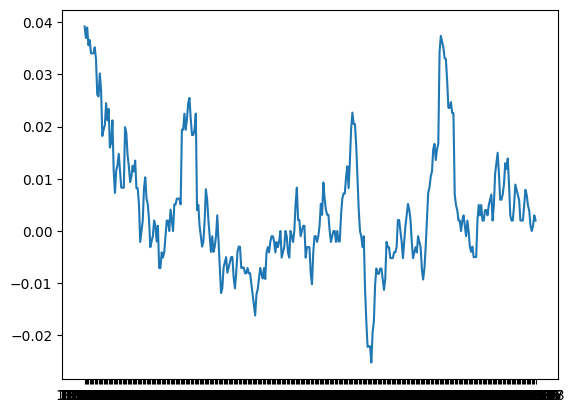

In [386]:
finalIndexMonthly.hist(layout=(10,3))
plt.show()

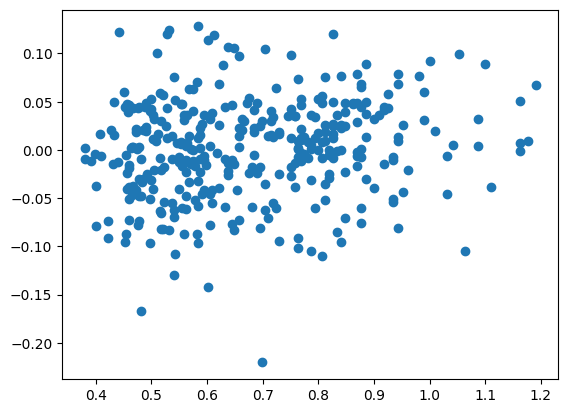

In [387]:
plt.scatter(finalIndexMonthly["B/M"], finalIndexMonthly["K1"])

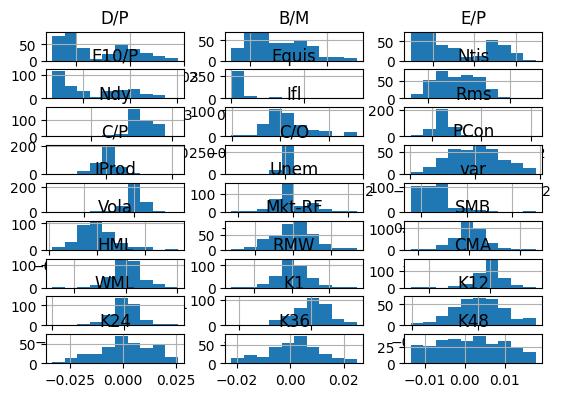

In [415]:
plt.plot(finalIndexMonthly.index, finalIndexMonthly["Ifl"])

In [416]:
finalIndexMonthly.describe()

,D/P,B/M,E/P,E10/P,Equis,Ntis,Ndy,Ifl,Rms,C/P,...,SMB,HML,RMW,CMA,WML,K1,K12,K24,K36,K48
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,...,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,347.000000,335.000000,323.000000,311.000000
mean,0.013774,0.675412,0.039718,0.012039,0.000900,0.017604,-2.188767,0.004025,0.002279,0.004521,...,0.001067,0.002157,0.001450,0.000144,0.000861,0.000960,0.000644,0.001078,0.001313,0.001306
std,0.006300,0.176496,0.020787,0.007209,0.002066,0.013014,0.078314,0.011668,0.002266,0.086026,...,0.031617,0.029145,0.021194,0.023632,0.043503,0.051854,0.018388,0.012594,0.009961,0.008249
min,0.005500,0.380228,0.011848,0.003500,0.000000,-0.010856,-2.733845,-0.025200,-0.004347,-0.403687,...,-0.115300,-0.142500,-0.080900,-0.129900,-0.198300,-0.220489,-0.050797,-0.033273,-0.021915,-0.013649
25%,0.008300,0.529101,0.021277,0.005363,0.000007,0.007245,-2.235110,-0.003100,0.001106,-0.036608,...,-0.015000,-0.013200,-0.009475,-0.011075,-0.017500,-0.030374,-0.011899,-0.007123,-0.004515,-0.004933
50%,0.011100,0.647256,0.031746,0.009002,0.000159,0.015781,-2.204448,0.002000,0.002187,0.011855,...,0.002350,0.002550,0.001100,0.000850,0.004950,0.002626,0.000527,0.001420,0.001897,0.001250
75%,0.019275,0.806452,0.061256,0.017945,0.000766,0.027721,-2.130326,0.008300,0.003173,0.055082,...,0.019750,0.017750,0.012825,0.012075,0.021400,0.035943,0.013028,0.011066,0.007633,0.008110
max,0.028900,1.190476,0.086957,0.030040,0.017385,0.065781,-1.968756,0.039200,0.021045,0.543624,...,0.131000,0.100500,0.087900,0.075400,0.149500,0.128005,0.043606,0.025901,0.024836,0.017832


In [388]:
test = finalIndexMonthly.iloc[:, :-5]
features = list(test.columns)
features.insert(0, "const")
X = test.values.tolist()
X = sm.add_constant(X)
y = finalIndexMonthly["K1"].tolist()

correlations = test.corr()

correlations

,D/P,B/M,E/P,E10/P,Equis,Ntis,Ndy,Ifl,Rms,C/P,...,IProd,Unem,var,Vola,Mkt-RF,SMB,HML,RMW,CMA,WML
D/P,1.000000,0.878758,0.924519,0.979612,0.067487,-0.558504,0.783946,-0.086736,0.205332,-0.057296,...,-0.114210,-0.015883,0.035618,0.019099,-0.003537,0.065888,-0.122661,0.011107,0.005273,-0.022406
B/M,0.878758,1.000000,0.815564,0.847941,0.131694,-0.366091,0.674199,-0.248634,0.139240,-0.043093,...,-0.067285,-0.047278,0.005867,0.010810,-0.010951,0.092501,-0.083446,0.019606,0.014239,-0.019647
E/P,0.924519,0.815564,1.000000,0.940962,0.033585,-0.514956,0.732764,0.061185,0.138903,-0.081748,...,-0.105846,-0.082556,0.066690,0.020027,-0.009158,0.052297,-0.104800,-0.001850,0.029463,-0.010749
E10/P,0.979612,0.847941,0.940962,1.000000,0.053215,-0.547231,0.767440,-0.102041,0.241165,-0.039489,...,-0.089741,-0.035999,-0.016168,0.016073,0.017824,0.071196,-0.131953,0.019956,-0.016541,-0.015903
Equis,0.067487,0.131694,0.033585,0.053215,1.000000,0.112218,0.027380,-0.188877,-0.043094,0.056444,...,0.095890,-0.084884,-0.008654,0.008344,-0.005824,0.036115,0.138064,0.021313,-0.023229,0.016883
Ntis,-0.558504,-0.366091,-0.514956,-0.547231,0.112218,1.000000,-0.523944,-0.118097,-0.154884,0.039284,...,0.063920,-0.046381,0.039717,-0.030149,-0.091525,0.003445,0.087926,0.060130,-0.037908,0.005917
Ndy,0.783946,0.674199,0.732764,0.767440,0.027380,-0.523944,1.000000,-0.036258,0.147318,-0.026942,...,-0.104374,-0.033731,0.037305,0.110479,-0.055950,0.045000,-0.101460,0.036788,-0.047469,0.003978
Ifl,-0.086736,-0.248634,0.061185,-0.102041,-0.188877,-0.118097,-0.036258,1.000000,-0.091868,-0.226461,...,-0.110901,-0.008730,0.476935,0.014938,-0.079899,-0.084735,-0.008885,-0.003424,0.098427,0.005872
Rms,0.205332,0.139240,0.138903,0.241165,-0.043094,-0.154884,0.147318,-0.091868,1.000000,0.153182,...,-0.045353,0.094643,-0.127594,-0.071828,0.057002,0.032546,-0.168408,0.026664,-0.114512,-0.006446
C/P,-0.057296,-0.043093,-0.081748,-0.039489,0.056444,0.039284,-0.026942,-0.226461,0.153182,1.000000,...,0.184944,-0.120190,-0.133068,-0.049910,0.158908,0.056661,-0.002207,-0.011851,-0.101950,-0.050247


In [389]:
ols = sm.OLS(y, X).fit()

print(ols.summary(xname=features))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.615
Date:                Sat, 17 Dec 2022   Prob (F-statistic):             0.0409
Time:                        12:33:28   Log-Likelihood:                 570.01
No. Observations:                 358   AIC:                            -1094.
Df Residuals:                     335   BIC:                            -1005.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1249      0.138      0.907      0.3

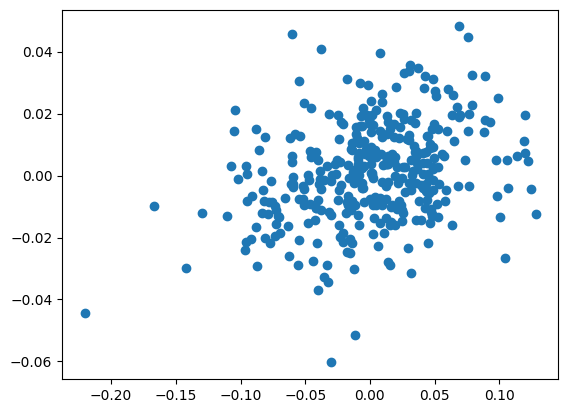

In [390]:
pred = ols.predict(X)
plt.scatter(y, pred)

VIF

In [391]:
vif_df = finalmonthlyOnlyIV
vif = pd.DataFrame()
vif["Variable"] = vif_df.columns
vif["VIF"] = [variance_inflation_factor(vif_df.values, column) for column in range(len(vif_df.columns))]

maxim = vif.loc[vif["VIF"] == vif["VIF"].max()].reset_index(drop=True)

maxim

while maxim["VIF"][0] > 10:
    vif_df = vif_df.drop(columns={maxim["Variable"][0]})
    vif = pd.DataFrame()
    vif["Variable"] = vif_df.columns
    vif["VIF"] = [variance_inflation_factor(vif_df.values, column) for column in range(len(vif_df.columns))]
    maxim = vif.loc[vif["VIF"] == vif["VIF"].max()].reset_index(drop=True)

vif

,Variable,VIF
0,E10/P,2.343496
1,Equis,1.331755
2,Ntis,1.629179
3,Ifl,1.173932
4,Rms,2.251596
5,C/P,1.219593
6,C/O,1.130782
7,PCon,1.109303
8,IProd,1.138909
9,Unem,1.094624


In [392]:
cols = vif_df.columns
X = finalIndexMonthly[cols]

#cols = cols.insert(0, "const")
y = finalIndexMonthly["K1"]

vif_ols = sm.OLS(y, X).fit()

print(vif_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                     K1   R-squared (uncentered):                   0.054
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              1.135
Date:                Sat, 17 Dec 2022   Prob (F-statistic):                       0.318
Time:                        12:33:28   Log-Likelihood:                          561.75
No. Observations:                 358   AIC:                                     -1089.
Df Residuals:                     341   BIC:                                     -1024.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Out of sample predictions

In [393]:
dates = finalIndexMonthly.loc["2002-01":].index
results = np.empty(shape=(0, 4))
predictions = []

for date in dates:
    out_of_sample = finalmonthlyOnlyIV.loc[date]
    df = finalIndexMonthly.loc[:date].iloc[:-1, :-4]
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:]
    ols = sm.OLS(y, X).fit()
    temp = np.matrix([[date] * len(ols.params)] + [ols.params.tolist()] + [ols.tvalues.tolist()] + [ols.params.index.tolist()])

    temp = np.transpose(temp)
    results = np.vstack((results, temp))

    prediction = [date, ols.predict(out_of_sample)[0]]
    predictions.append(prediction)

pred_df = pd.DataFrame(predictions)
pred_df = pred_df.rename(columns={0: "Date", 1: "Pred"})
pred_df.set_index('Date', inplace=True)

results = pd.DataFrame(results)
results = results.rename(columns={0: "Date", 1: "Coef", 2: "T-val", 3: "Variable"})
results.set_index("Date", inplace=True)

results[["Coef", "T-val"]] = results[["Coef", "T-val"]].apply(pd.to_numeric)
results = results.round(2)
results

,Coef,T-val,Variable
Date,,,
2002-01,16.14,1.28,D/P
2002-01,-0.07,-0.22,B/M
2002-01,-5.92,-2.23,E/P
2002-01,19.38,1.06,E10/P
2002-01,5.30,1.48,Equis
...,...,...,...
2020-08,-0.12,-1.34,SMB
2020-08,-0.11,-0.86,HML
2020-08,-0.17,-0.88,RMW


In [394]:
df2 = pred_df.merge(finalIndexMonthly["K1"], on="Date")
df2

,Pred,K1
Date,,
2002-01,0.015090,0.040751
2002-02,0.020116,0.048307
2002-03,0.012254,0.020142
2002-04,0.000218,0.035865
2002-05,0.033091,-0.087744
...,...,...
2020-04,0.001692,0.068696
2020-05,-0.018219,0.000052
2020-06,-0.043986,-0.035390


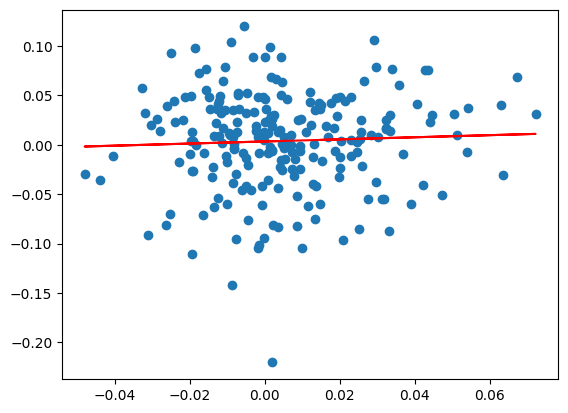

In [395]:
X = sm.add_constant(df2["Pred"])
y = df2["K1"]
reg = sm.OLS(y, X).fit()

coef, intrcpt = np.polyfit(df2["Pred"], y, 1)
plt.scatter(df2["Pred"], df2["K1"])
plt.plot(df2["Pred"], coef*df2["Pred"] + intrcpt, color="red")

In [396]:
np.corrcoef(df2["Pred"], df2["K1"])

array([[1.        , 0.04521209],
       [0.04521209, 1.        ]])

Logistic regression

In [397]:
results_log = np.empty(shape=(0, 4))
predictions_log = []

log_df = finalIndexMonthly.iloc[:-1, :-4].copy()
log_df.loc[log_df["K1"] < 0, "K1" ] = 0
log_df.loc[log_df["K1"] > 0, "K1" ] = 1

for date in dates:
    out_of_sample = finalmonthlyOnlyIV.loc[date]
    df = log_df.loc[:date]
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:]
    glm = sm.GLM(y, X, family=sm.families.Binomial()).fit()
    temp = np.matrix([[date] * len(glm.params)] + [glm.params.tolist()] + [glm.tvalues.tolist()] + [glm.params.index.tolist()])

    temp = np.transpose(temp)
    results_log = np.vstack((results_log, temp))

    prediction = [date, glm.predict(out_of_sample)[0]]
    predictions_log.append(prediction)

pred_df_log = pd.DataFrame(predictions_log)
pred_df_log = pred_df_log.rename(columns={0: "Date", 1: "Pred"})
pred_df_log.set_index('Date', inplace=True)

results_log = pd.DataFrame(results_log)
results_log = results_log.rename(columns={0: "Date", 1: "Coef", 2: "T-val", 3: "Variable"})
results_log.set_index("Date", inplace=True)

results_log[["Coef", "T-val"]] = results_log[["Coef", "T-val"]].apply(pd.to_numeric)
results_log = results_log.round(2)

pred_df_log.loc[pred_df_log["Pred"] < 0.5, "Pred" ] = 0
pred_df_log.loc[pred_df_log["Pred"] >= 0.5, "Pred" ] = 1

pred_df_log = pred_df_log.merge(log_df["K1"], on="Date")
pred_df_log

,Pred,K1
Date,,
2002-01,1.0,1.0
2002-02,0.0,1.0
2002-03,0.0,1.0
2002-04,0.0,1.0
2002-05,1.0,0.0
...,...,...
2020-03,1.0,1.0
2020-04,1.0,1.0
2020-05,1.0,1.0


In [398]:
confusion_matrix = pd.crosstab(pred_df_log['K1'], pred_df_log['Pred'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted  0.0  1.0
Actual             
0.0         44   49
1.0         29  101
